# 第二章

In [1]:
# !pip install pandas_datareader

In [6]:
#导入必要的库
from pandas_datareader import data as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
import QUANTAXIS as QA

In [8]:
#指定下载股票的日期范围
start_date = '2020-01-01'
end_date = '2020-03-20'
#使用yahoo数据源
# zgpa = dt.DataReader('601318.ss','yahoo',start_date,end_date)

In [15]:
zgpa = QA.QA_fetch_stock_day_adv('601318',start_date,end_date).data

In [29]:
zgpa = zgpa.droplevel('code')

In [30]:
# 检查数据
zgpa.head()

,open,high,low,close,volume,amount
date,,,,,,
2020-01-02,85.90,86.79,85.88,86.12,778252.0,6.712531e+09
2020-01-03,86.81,86.88,85.90,86.20,594980.0,5.137312e+09
2020-01-06,85.92,86.87,85.50,85.60,636448.0,5.487968e+09
2020-01-07,86.01,86.46,85.67,86.15,452188.0,3.886450e+09
2020-01-08,85.98,85.98,84.50,85.00,628053.0,5.347387e+09


In [31]:
# 信号
#建立一个新数据
zgpa_signal = pd.DataFrame(index=zgpa.index)
zgpa_signal['price'] = zgpa['close']
#增加一个字段显示价格变化
zgpa_signal['diff'] = zgpa_signal['price'].diff()
#数据清理
zgpa_signal = zgpa_signal.fillna(0.0)
#对数据进行分类，股价上涨或保持，则为0
zgpa_signal['signal'] = np.where(zgpa_signal['diff'] >=0, 0, 1)
#根据信号变化进行下单
zgpa_signal['order'] = zgpa_signal['signal'].diff()*100

In [ ]:
# #创建交易信号
# #建立一个新数据
# zgpa_signal = pd.DataFrame(index=zgpa.index)
# zgpa_signal['price'] = zgpa['Adj Close']
# #增加一个字段显示价格变化
# zgpa_signal['diff'] = zgpa_signal['price'].diff()
# #数据清理
# zgpa_signal = zgpa_signal.fillna(0.0)
# #对数据进行分类，股价上涨或保持，则为0
# zgpa_signal['signal'] = np.where(zgpa_signal['diff'] >=0, 0, 1)
# #根据信号变化进行下单
# zgpa_signal['order'] = zgpa_signal['signal'].diff()*100

In [32]:
zgpa_signal.head()

,price,diff,signal,order
date,,,,
2020-01-02,86.12,0.00,0,NaN
2020-01-03,86.20,0.08,0,0.0
2020-01-06,85.60,-0.60,1,100.0
2020-01-07,86.15,0.55,0,-100.0
2020-01-08,85.00,-1.15,1,100.0


## 回测

In [33]:
# 给2万的初始资金
initial_cash = 20000
#增加一个字段，代表交易股票的市值
zgpa_signal['stock'] = zgpa_signal['order']*zgpa_signal['price']
#两次买卖订单变化只差就是仓仓位的变化，
#持仓股票数量变化乘以现价，就是交易产生的现金流
#用初始资金减去现金变化的累加，就是剩余的现金
zgpa_signal['cash'] = initial_cash - (zgpa_signal['order'].diff()*zgpa_signal['price']).cumsum()
#股票市值+剩余现金 = 总资产
zgpa_signal['total'] = zgpa_signal['stock'] + zgpa_signal['cash']

展示资产变化

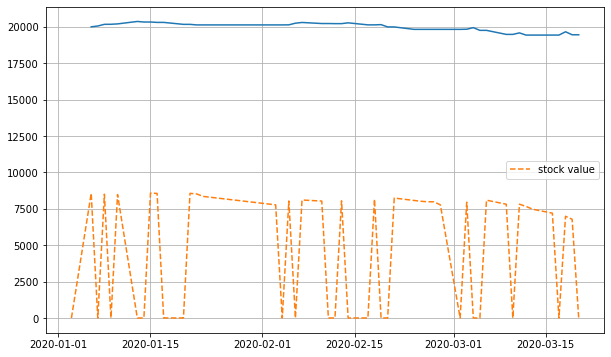

In [34]:
plt.figure(figsize=(10,6))
#分别绘制总资产和持仓市值变化
plt.plot(zgpa_signal['total'])
plt.plot(zgpa_signal['order'].cumsum()*zgpa_signal['price'],'--',label='stock value')
#增加网格，调整一下图注的位置
plt.grid()
plt.legend(loc='center right')
plt.show()

## 2.2 经典策略之移动平均策略

### 2.2.1 单一移动平均

In [35]:
# 使用10日均线
period = 10
# 设置一个空列表，用来存储每10天的价格
avg_10 = []
# 再设置一个空列表，用来存储每10天的均价
avg_value = []
# 设置一个循环
for price in zgpa['close']:
    avg_10.append(price)
    #保持10个价格
    if len(avg_10) > period:
        del avg_10[0]
    # 将10天数据的均值传入avg_value列表
    avg_value.append(np.mean(avg_10))
# 把计算好的10日均价写到股票价格数据表中
zgpa = zgpa.assign(avg_10 = pd.Series(avg_value,index = zgpa.index))

In [36]:
zgpa.head()

,open,high,low,close,volume,amount,avg_10
date,,,,,,,
2020-01-02,85.90,86.79,85.88,86.12,778252.0,6.712531e+09,86.120000
2020-01-03,86.81,86.88,85.90,86.20,594980.0,5.137312e+09,86.160000
2020-01-06,85.92,86.87,85.50,85.60,636448.0,5.487968e+09,85.973333
2020-01-07,86.01,86.46,85.67,86.15,452188.0,3.886450e+09,86.017500
2020-01-08,85.98,85.98,84.50,85.00,628053.0,5.347387e+09,85.814000


**展示**

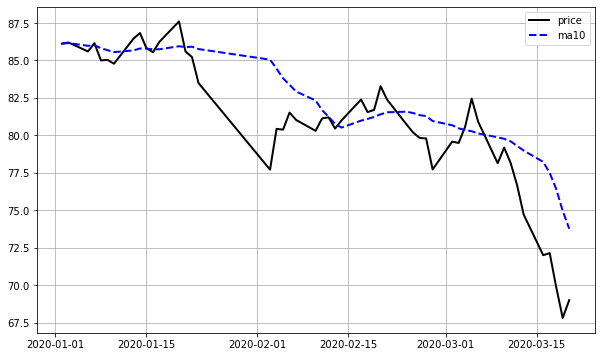

In [38]:
# 设置图形尺寸为 10*6
plt.figure(figsize = (10,6))
# 绘制股价变化
plt.plot(zgpa['close'], lw=2, c='k', label = 'price')
# 绘制10日均线
plt.plot(zgpa['avg_10'],'--',lw=2,c='b', label = 'ma10')
plt.legend()
plt.grid()
plt.show()

###  双移动平均策略 (2.2.2)

In [40]:
# 建立一个新数据表，命名为strategy
strategy = pd.DataFrame(index=zgpa.index)
# 添加一个signal字段，用来存储交易信号
strategy['signal'] = 0
#  ma5
strategy['avg_5'] = zgpa['close'].rolling(5).mean()
strategy['avg_10'] = zgpa['close'].rolling(10).mean()
# 交易信号
strategy['signal'] = np.where(strategy['avg_5']>strategy['avg_10'],1,0)
strategy['order'] = strategy['signal'].diff()
strategy.tail(10)

,signal,avg_5,avg_10,order
date,,,,
2020-03-09,1,80.314,79.868,0.0
2020-03-10,1,80.252,79.767,0.0
2020-03-11,1,79.766,79.599,0.0
2020-03-12,0,78.606,79.285,-1.0
2020-03-13,0,77.366,78.984,0.0
2020-03-16,0,76.138,78.226,0.0
2020-03-17,0,74.730,77.491,0.0
2020-03-18,0,73.074,76.420,0.0
2020-03-19,0,71.306,74.956,0.0
